<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="800">

# Андан на экономе: домашнее задание 3
</center>

**ФИО:** Волчкова Ольга Александровна

## Общая информация

__Дата выдачи:__ 03.03.2025

__Мягкий дедлайн:__ 23:59MSK 20.03.2025

__Жесткий дедлайн:__ 23:59MSK 23.03.2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

На семинаре мы попытались разобраться как устроена процедура АБ-тестирования. В этом задании мы попытаемся закрепить полученные знания и более аккуратно структурировать их.

### Кратко повторим теорию

Мы хотим выктить новую функциональность на сайте. Перед раскаткой нам хочется проверить, какой эффект мы оказываем на пользователя. Выделим две выборки: тестовую (treatment) и контрольную (control). Тестовой покажем новый сайт. Контрольной старый. Замерим инетерсующую нас метрику, нааример, время проведенной на сайте, в обеих группах:

$$
\begin{aligned}
&X^c_1, \ldots, X^c_{n_c} \sim iid (\mu_c, \sigma^2_c) \\
&X^t_1, \ldots, X^t_{n_t} \sim iid (\mu_t, \sigma^2_t)
\end{aligned}
$$

У выборок есть какие-то математические ожидания, дисперсии. Выборки собраны независимо друг от друга. Если их математические ожидания одинаковые, будем считать, что новая функциональность никак не повлияла на пользователей. Сформулируем это в виде нашей нулевой гипотезы: 

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_c = \mu_t \\
&H_1: \hspace{2mm} \mu_c < \mu_t.
\end{aligned}
$$

Посчитаем по выборке расстояние между математическими ожиданиями $\hat \mu_t - \hat \mu_c$. Оно по ЦПТ имеет нормальное распределение с дисперсией $\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}$. Получается, что 

$$
z = \frac{\hat \mu_t - \hat \mu_c}{\sqrt{\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}}} \sim N(0,1),
$$

при верности нулевой гипотезы и $n \to \infty$. Если это расстояние оказывается слишком большим, мы отказываемся верить в нулевую гипотезу. Эффект от новой функциональности есть. Будем сравнивать наблюдаемое значение $z$ с $z_{1 - \alpha},$ где уровень значимости $\alpha$ выберем до начала эксперимента. 

- Если $z < z_{1 - \alpha},$ нулевая гипотеза верна. Расстояние маленькое, разницы нет. 
- Если $z > z_{1 - \alpha},$ выбираем альтернативу. У на есть значимый эффект на метрику, от веры в нулевую гипотезу придётся отказаться. 

> Ничего не понятно? Тогда вам в лекции. Ниже подборка:  

- [Наш семинар про АБ](https://youtu.be/Iv9kH_vr8Io)
- [Неделя про проверку гипотез с курсеры](https://www.youtube.com/watch?v=Zv-5gbJtofk&list=PLCf-cQCe1FRxTgNPwcRSkBjvtE8DEm7rU)

Мои лекции из маги ФКН:

- [Лекция про базовые поняия в АБ](https://www.youtube.com/watch?v=LojpDrkLhmo)
- [Лекция про планирование АБ](https://www.youtube.com/watch?v=ZsE-MOCYeLs)
- [Всё то же самое, но ещё есть про roc-auc](https://www.youtube.com/watch?v=aZI3D8qEHHo)

## Задания


__а) [10 баллов]__ Реализуйте функцию для проверки гипотезы о равенстве математических ожиданий. Она должна принимать на вход две выборки и выдавать на выход наблюдаемое значение статистики `z_obs` и `p_value` для ситуаций с разными альтернативными гипотезами.

In [22]:
def asy_mean_test(x_control, x_treatment, alternative = 'larger'):
    p_control = x_control.mean()
    p_treatment = x_treatment.mean()
    var_c = np.var(x_control, ddof = 1)
    var_t = np.var(x_treatment, ddof = 1)
    diff = p_treatment - p_control
    n_c = len(x_control)
    n_t = len(x_treatment)
    diff_std = np.sqrt(var_c / n_c + var_t / n_t)
    z_obs = diff/diff_std

    if alternative == 'larger':
        p_value = 1 - stats.norm().cdf(z_obs)
    elif alternative == 'two-sided':
        p_value = 2 * (1 - stats.norm().cdf(np.abs(z_obs)))
    elif alternative == 'smaller':
        p_value = stats.norm().cdf(z_obs)
    return z_obs, p_value

Если вы написали весь код выше корректно, то строки ниже сработают без проблем.

In [23]:
def gen_sample(n_obs, effect, p_control):
    p_treatment = p_control * (1 + effect)
    x_control = stats.bernoulli(p_control).rvs(n_obs)
    x_treatment = stats.bernoulli(p_treatment).rvs(n_obs)
    return x_control, x_treatment

In [24]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0, 0.2))
assert pval > 0.01

In [25]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0.1, 0.2))
assert pval < 0.01

Для простоты мы дальше будем работать с односторонней альтернативой и тестом для долей. 

$$
\begin{aligned}
&H_0: \hspace{2mm} p_t = p_c \\
&H_1: \hspace{2mm} p_t > p_c 
\end{aligned}
$$

__б) [20 баллов]__ Предположим, что нулевая гипотеза верна. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы.

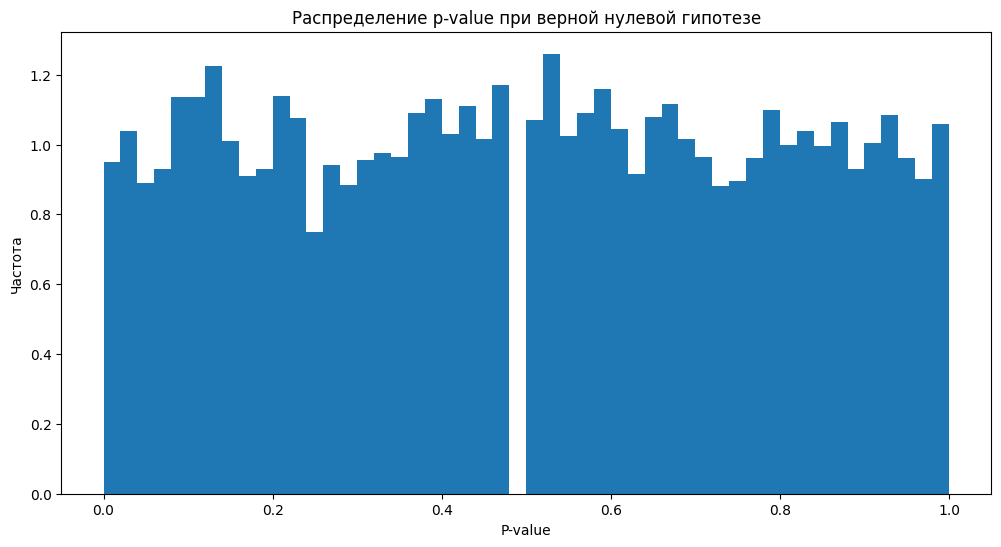

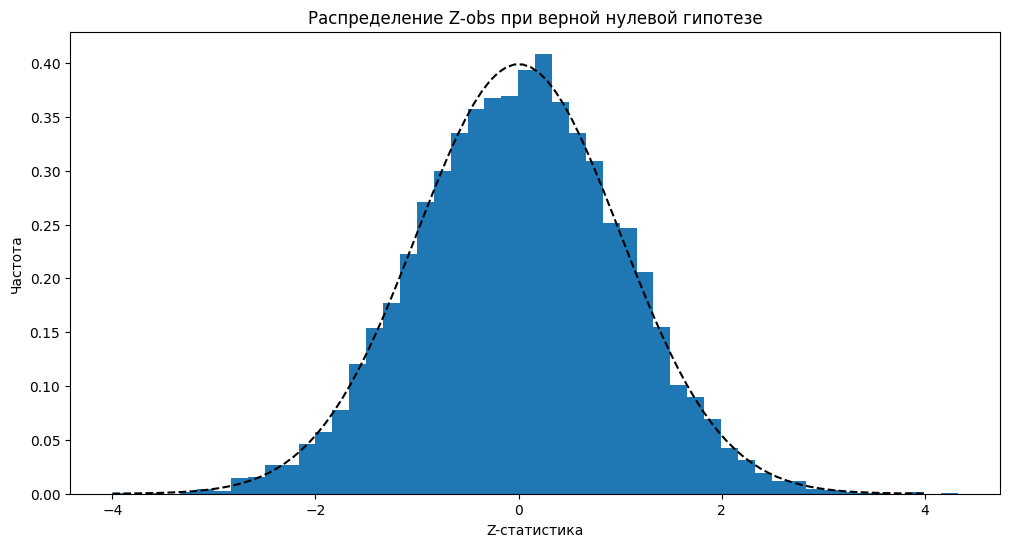

In [26]:
n_obs = 10**4
n = 1000
p_control = 0.2
effect = 0

pvalue_list_0 = []
z_obs_list_0 = []
for i in range(n_obs):
    x_control, x_treatment = gen_sample(n, effect, p_control)
    z_obs, p_value = asy_mean_test(x_control, x_treatment, alternative='larger')
    pvalue_list_0.append(p_value)
    z_obs_list_0.append(z_obs)

plt.figure(figsize=(12, 6))
plt.hist(pvalue_list_0, bins=50, density=True)
plt.xlabel('P-value')
plt.ylabel('Частота')
plt.title('Распределение p-value при верной нулевой гипотезе')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(z_obs_list_0, bins=50, density=True)
x = np.linspace(-4, 4, 100)
plt.plot(x, stats.norm.pdf(x, loc=0, scale=1), '--k', label='Standard Normal PDF')
plt.xlabel('Z-статистика')
plt.ylabel('Частота')
plt.title('Распределение Z-obs при верной нулевой гипотезе')
plt.show()

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__

Да, правда, p_value имеет равномерное распределение на отрезке $[0;1]$. Это происходит потому, что $p$-значение — это  вероятность получить для данного распределения случайной величины такое же или более экстремальное значение статистики при условии, что $H_0$ верна. То есть, так как у нас $H_0$ верна - p_value это случайная величина, так как $p \in [0;1]$, и испытания независимы, p_value равновероятно может оказаться в любой точке отрезка, следовательно будет иметь равномерное распределение.

Z_obs имеет стандартное нормальное распределение, то есть мат ожидание = 0. Z_obs мы рассчитываем как разницу между мат ожиданиями control и treatment и делим на стандартное отклонение, то есть, фактически, приводим случайную величину к стандартной нормальной. Так как при верности $H_0$ разница между средним control и treatment = 0, то есть у нас получился вектор из стандартных нормальных величин, следовательно, распределение стандартное нормальное

__в) [10 баллов]__ Предположим, что верна альтернативная гипотеза. Доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы и прокомментируйте получившиеся результаты.

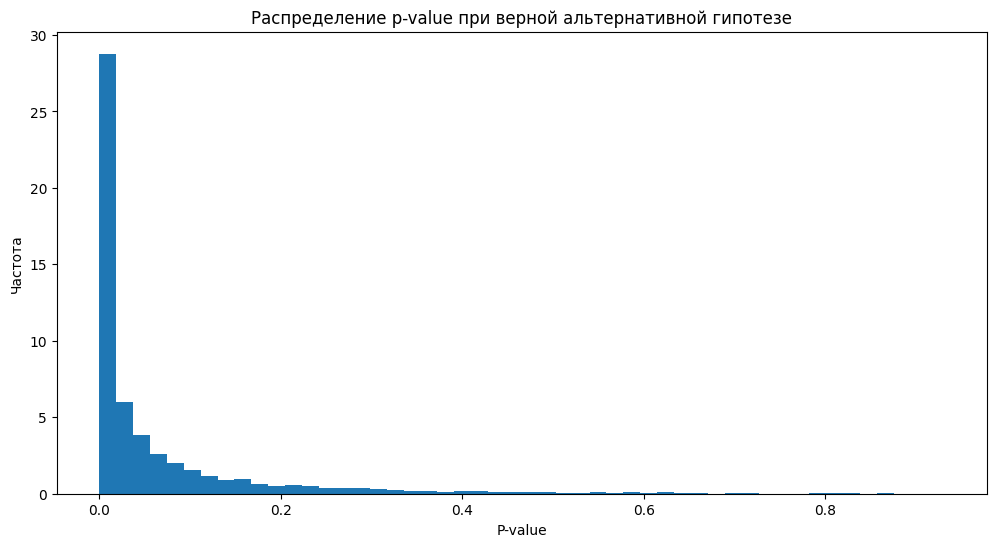

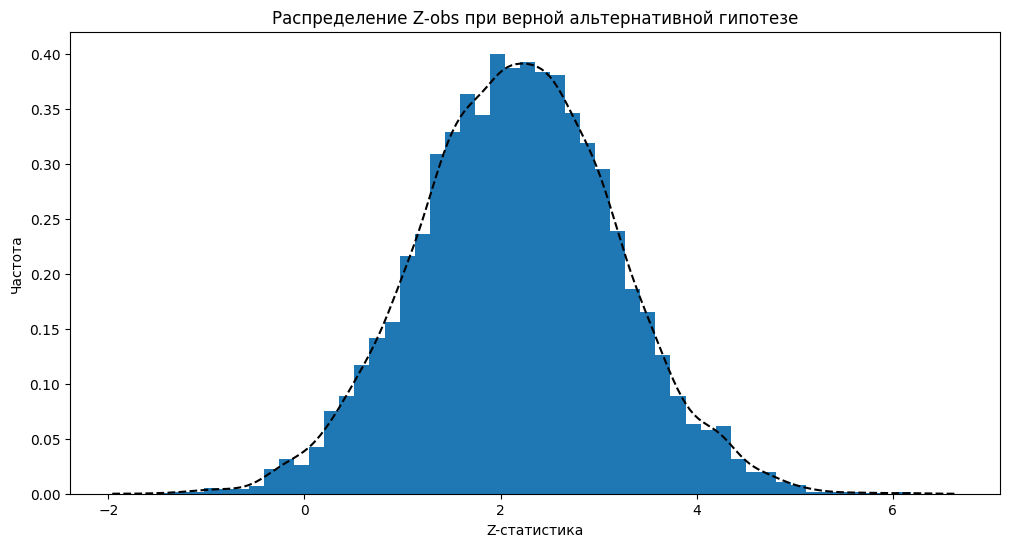

In [27]:
n_obs = 10**4
n = 1000
alpha = 0.05 
p_control = 0.2
effect = 0.2

pvalue_list_02 = []
z_obs_list_02 = []
for i in range(n_obs):
    x_control, x_treatment = gen_sample(n, effect, p_control)
    z_obs, p_value = asy_mean_test(x_control, x_treatment, alternative='larger')
    pvalue_list_02.append(p_value)
    z_obs_list_02.append(z_obs)

plt.figure(figsize=(12, 6))
plt.hist(pvalue_list_02, bins=50, density = True)
plt.xlabel('P-value')
plt.ylabel('Частота')
plt.title('Распределение p-value при верной альтернативной гипотезе')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(z_obs_list_02, bins=50, density = True)
sns.kdeplot(z_obs_list_02, color = 'black', linestyle='--')
plt.xlabel('Z-статистика')
plt.ylabel('Частота')
plt.title('Распределение Z-obs при верной альтернативной гипотезе')
plt.show()

Комментарий: В отличие от предыдущей генерации, здесь p_value значительно смещен в сторону 0, а z_obs сместилась вправо и стало выглядеть как нормальное распределение с математическим ожиданием = 2

А как будут выглядеть результаты, если доля в тестовой выборке больше на $40\%$? Проведите симуляции.

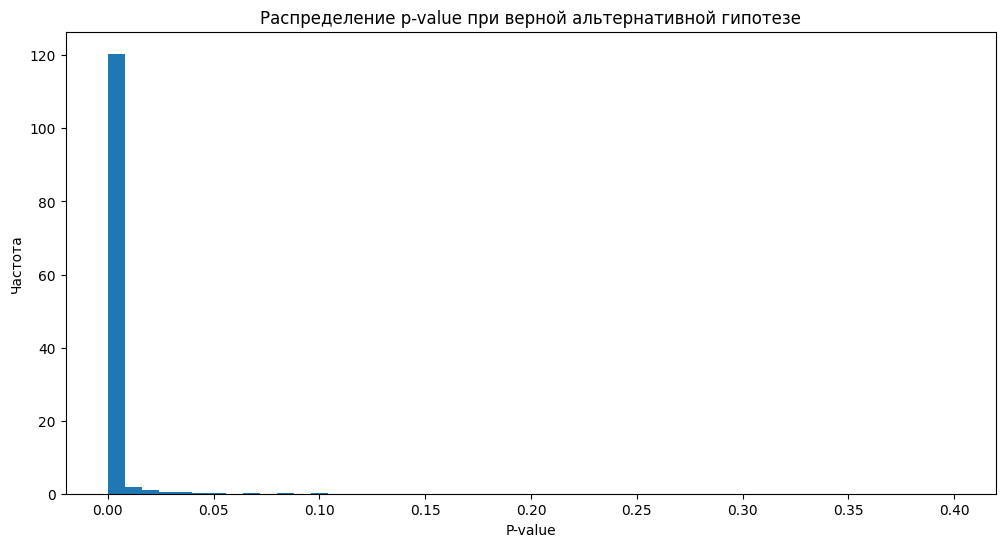

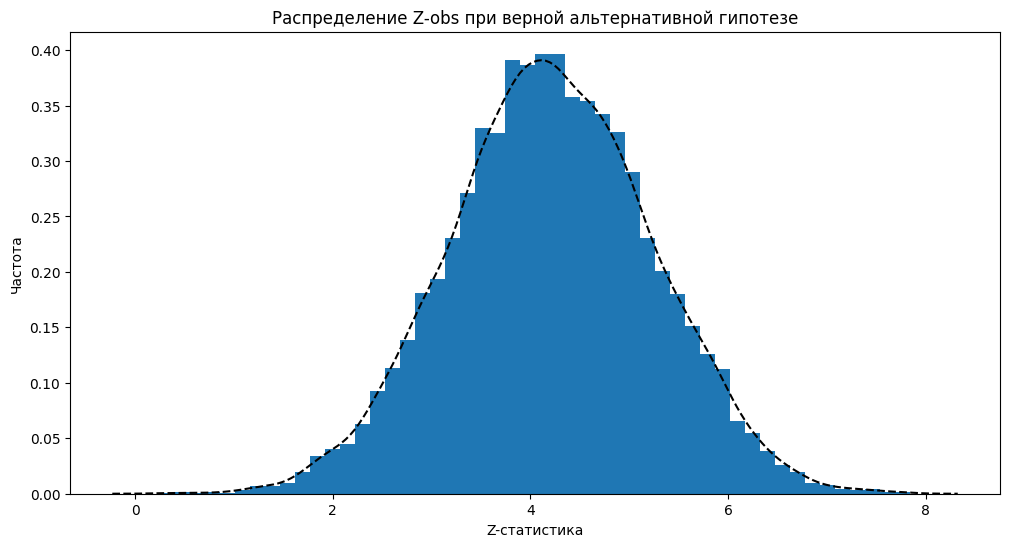

In [28]:
n_obs = 10**4
n = 1000
alpha = 0.05 
p_control = 0.2
effect = 0.4

pvalue_list_04 = []
z_obs_list_04 = []
for i in range(n_obs):
    x_control, x_treatment = gen_sample(n, effect, p_control)
    z_obs, p_value = asy_mean_test(x_control, x_treatment, alternative='larger')
    pvalue_list_04.append(p_value)
    z_obs_list_04.append(z_obs)

plt.figure(figsize=(12, 6))
plt.hist(pvalue_list_04, bins=50, density=True)
plt.xlabel('P-value')
plt.ylabel('Частота')
plt.title('Распределение p-value при верной альтернативной гипотезе')
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(z_obs_list_04, bins=50, density=True)
sns.kdeplot(z_obs_list_04, color = 'black', linestyle='--')
plt.xlabel('Z-статистика')
plt.ylabel('Частота')
plt.title('Распределение Z-obs при верной альтернативной гипотезе')
plt.show()

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__

Нет, неправда. Теперь когда верна $H_1$ распределение p_value не является равномерным. Оно смещается в сторону 0 тем больше, чем выше значение effect (отклонение альтернативной гипотезы от нулевой). У нас верна альтернативная гипотеза, мы отвегаем нулевую гипотезу, когда p_value меньше уровня значимости, поэтому значения p_value у нас смещаются в сторону 0.

Z_obs в случае с effect = 20% имеет нормальное распределение с мат ожиданием, примерно равным 2, если effect = 40% - с мат ожиданием примерно равным 4. При верной $H_1$ значение оценки $\overline{\theta}$ должно сходиться к $\theta_1$, поэтому получится что мат ожидание будет изменяться пропорционально значению effect

__г) [10 баллов]__ Обычно, перед началом эксперимента, мы фиксируем ошибку первого рода, вероятность отвергнуть нулевую гипотезу, когда она на самом деле верна,  

$$\alpha = \mathbb{P}(H_A \mid H_0).$$

Дальше мы принимаем решение, о том, какую гипотезу выбрать, сравнивая `z_obs` с $z_{1 - \alpha},$ либо `pvalue` с $\alpha$ (напомню что мы делаем симуляции для правосторонней альтернативы, поэтому $\alpha$ не надо делить на два). 

Давайте проверим для конкретного $\alpha$, что это правда работает. Выберите любое разумное значение $\alpha$. С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$ при верности нулевой гипотезы. Проверьте эти гипотезы и оцените получившееся значение $\alpha$. Правда ли, что оно оказалось равно заявленному значению? 

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [ ]:
alpha = 0.05

pval_reject = [p_value < alpha for p_value in pvalue_list_0]
a_emp_pvalue = np.mean(pval_reject)

z_cr = stats.norm.ppf(1 - alpha)
z_obs_reject = [z_obs > z_cr for z_obs in z_obs_list_0]
a_emp_z_obs = np.mean(z_obs_reject)

print(f"Эмпирическая alpha по p-value: {a_emp_pvalue}")
print(f"Эмпирическая alpha по z_obs: {a_emp_z_obs}")
print(f"Заявленная alpha: {alpha}")

Эмпирическая alpha по p-value: 0.05
Эмпирическая alpha по z_obs: 0.05
Заявленная alpha: 0.05


__Ответ:__ Да, правда, альфа равна заявленному значению

Кроме ошибки первого рода есть ещё и ошибка второго рода, вероятность остаться с нулевой гипотезой, когда верна альтернатива,

$$\beta = \mathbb{P}(H_0 \mid H_A).$$

Давайте предположим, что доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. С помощью симуляций того же самого объёма оцените, чему равна $\beta$. 

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [ ]:
accepted_pvalue = [p_value >= alpha for p_value in pvalue_list_02]
beta_emp_pvalue = np.mean(accepted_pvalue)

z_critical = stats.norm.ppf(1 - alpha)
accepted_zobs = [z_obs <= z_critical for z_obs in z_obs_list_02]
beta_emp_zobs = np.mean(accepted_zobs)

print(f"Эмпирическая beta (по p-value): {beta_emp_pvalue}")
print(f"Эмпирическая beta (по z-obs): {beta_emp_zobs}")
print(f"1-beta по p_value: {1 - beta_emp_pvalue}")
print(f"1-beta по z_obs: {1 - beta_emp_pvalue}")

Эмпирическая beta (по p-value): 0.3008
Эмпирическая beta (по z-obs): 0.3008
1-beta по p_value: 0.6992
1-beta по z_obs: 0.6992


Теперь доля в тестовой выборке оказалась на $40\%$ больше, чем в контрольной. Чем равна $\beta$ здесь?

In [ ]:
accepted_pvalue = [p_value >= alpha for p_value in pvalue_list_04]
beta_emp_pvalue = np.mean(accepted_pvalue)

z_critical = stats.norm.ppf(1 - alpha)
accepted_zobs = [z_obs <= z_critical for z_obs in z_obs_list_04]
beta_emp_zobs = np.mean(accepted_zobs)

print(f"Эмпирическая beta (по p-value): {beta_emp_pvalue}")
print(f"Эмпирическая beta (по z-obs): {beta_emp_zobs}")
print(f"1-beta по p_value: {1 - beta_emp_pvalue}")
print(f"1-beta по z_obs: {1 - beta_emp_pvalue}")

Эмпирическая beta (по p-value): 0.0052
Эмпирическая beta (по z-obs): 0.0052
1-beta по p_value: 0.9948
1-beta по z_obs: 0.9948


Что с ошибкой второго рода происходит при росте эффекта? Что происходит с ней, если при проверке гипотезы взять более маленькое $\alpha$?

__Ответ:__ При росте эффекта ошибка второго рода уменьшается, потому что чем больше effect, тем выше разница между двумя группами, поэтому тест реже пропускает случай, когда нулевая гипотеза ложная. 

Если взять более маленькое альфа, то ошибка второго рода увеличится. Когда мы уменьшаем альфу, мы увеличиваем вероятность того, что нулевая гипотеза верная, потому что для этого pvalue надо будет преодолеть более строгое значение, поэтому мы увеличиваем вероятность того, что $H_0$ будет принята даже если она ложная

__д) [10 баллов]__ Ошибки $\alpha$ и $\beta$ связаны между собой. Чем выше, при фиксированном размере выборки и эффекта мы делаем одну, тем ниже другая. Давайте попробуем в рамках проделанных выше симуляций нарисовать взаимосвязь между ошибками.

Выше, для оценки $\beta$ вы сравнивали вектор `pval` с зафиксированным значением `alpha`.  Переберите `alpha` по циклу от 0 до 1 с шагом 0.01 и оцените для каждого значения `alpha` значение `beta`. 

Нарисуйте получившуюся взаимосвязь на графике для эффекта в 20% и 40%. Какая из кривых идёт ниже? 

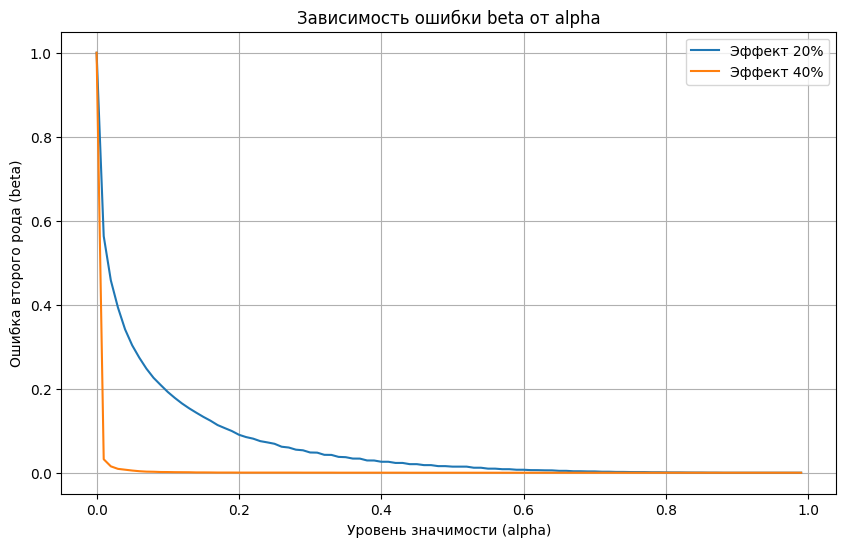

In [12]:
alpha_values = np.arange(0, 1, 0.01)
def calc_beta(alpha_values, pvalue_list_02, pvalue_list_04):
    beta_values_04 = []
    beta_values_02 = []
    for alpha in alpha_values:
        beta_04= np.mean(np.array(pvalue_list_04) > alpha)
        beta_02 = np.mean(np.array(pvalue_list_02) > alpha)
        beta_values_04.append(beta_04)
        beta_values_02.append(beta_02)
    return beta_values_02, beta_values_04

beta_values_02, beta_values_04 = calc_beta(alpha_values, pvalue_list_02, pvalue_list_04)
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, beta_values_02, label="Эффект 20%")
plt.plot(alpha_values, beta_values_04, label="Эффект 40%")
plt.xlabel("Уровень значимости (alpha)")
plt.ylabel("Ошибка второго рода (beta)")
plt.title("Зависимость ошибки beta от alpha")
plt.legend()
plt.grid()
plt.show()                

__Ответ:__ Ниже идет кривая с эффектом 40%, потому что при большем эффекте данные сильнее отклоняются от $H_0$. То есть для него нужно меньшее, чем у эффекта = 20%, увеличение уровня значимости чтобы снизить ошибку второго рода

Нарисуйте точно такую же кривую для ситуации, когда была верна нулевая гипотеза.

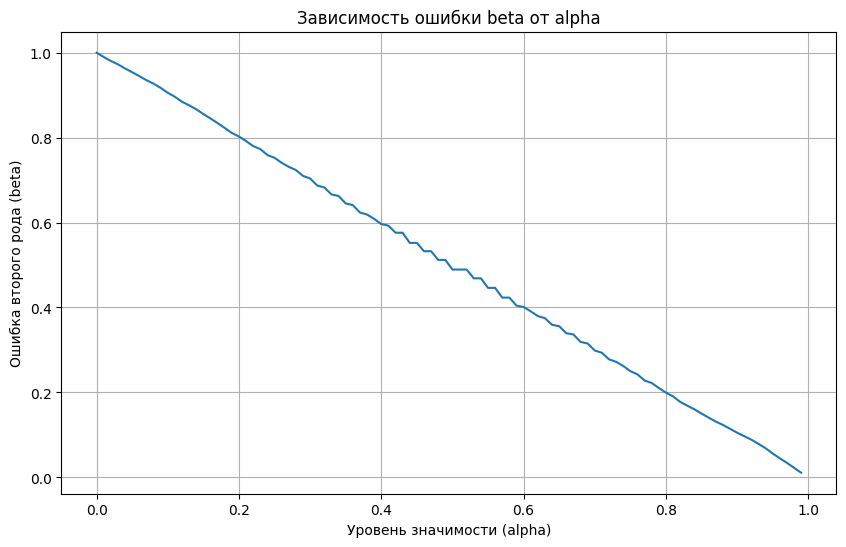

In [13]:
alpha_values = np.arange(0, 1, 0.01)
def calc_beta(alpha_values, pvalue_list_0):
    beta_values_0 = []
    for alpha in alpha_values:
        beta_0= np.mean(np.array(pvalue_list_0) > alpha)
        beta_values_0.append(beta_0)
    return beta_values_0
beta_values_0 = calc_beta(alpha_values, pvalue_list_0)
plt.figure(figsize=(10, 6))
plt.plot(alpha_values, beta_values_0)
plt.xlabel("Уровень значимости (alpha)")
plt.ylabel("Ошибка второго рода (beta)")
plt.title("Зависимость ошибки beta от alpha")
plt.grid()
plt.show()       

Вместо осей $(\alpha, \beta)$ обычно такой график рисуют в осях $(\alpha, 1 - \beta)$. Давайте построим его и проинтерпретируем. 

In [14]:
def plot_pvalue_distribution(dict_pvalues):
    xseq = np.linspace(0, 1, 1000)

    for key, pvalues in dict_pvalues.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=key)
    
    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Распределение p-value/ROC-кривая', size=16)
    plt.xlabel('alpha', size=12)
    plt.ylabel('1 - beta', size=12)
    plt.legend(fontsize=12)
    plt.grid()

Заполните пропуски в коде ниже, чтобы для нашего АБ-теста отрисовались ROC-кривые.

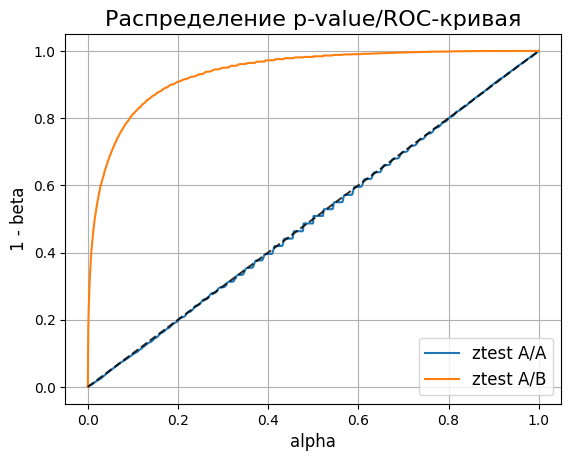

In [15]:
n_sim = 10**4
sample_size = 1000

dict_pvalues = defaultdict(list)
for _ in range(n_sim):
    x_control, x_treatment = gen_sample(sample_size, effect=0.2, p_control=0.2)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    x_control_again, _ = gen_sample(sample_size, effect=0, p_control=0.2)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    x_control_again, _ = gen_sample(1000, 0, 0.2)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    dict_pvalues['ztest A/A'].append(pval_aa)
    dict_pvalues['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(dict_pvalues)

Получившийся график можно проинтерпретировать двумя способами. Мы много-много раз проводим АБ-тест. В начале теста мы зафиксировали какую-то $\alpha$ и дальше проверяем кучу гипотез.

1. Линия `ztest A/A` это функция распределения pvalue при верности нулевой гипотезы. Оно было равномерным, мы двигаем $alpha$ по оси $OX$ и оцениваем $\mathbb{P}(\text{pvalue} \le \alpha) = F(\alpha)$.  

По аналогии, линия `ztest A/B` это функция распределения pvalue при верности альтернативной гипотезы.

2. Линию `ztest A/B` можно проинтерпретировать как ROC-кривую. Если вы уже знаете про задачу классификации из машинного обучения, то это ровно оно. Полнота это $1 - \beta$, то есть то, сколько верных альтернативных гипотез мы найдём, если будем использовать наш АБ-тест, FPR это $\alpha$, то есть то, сколько верных нулевых гипотез мы заберём с собой в альтернативные. Эту величину мы определяем до старта эксперимента.

> Важно: если вы не поняли интерпретацию из пункта 2, просто забейте. Заботаете МО, поймёте. Интерпретацию из пункта 1 должны понять все. Если вы её не поняли, время напрячься и подумать ещё разок.

__Что для нас важно:__ 

- Чем выпуклее график, тем лучше мы находим эффект и процедура проверки гипотезы работае корректно;
- Чем больше у нас наблюдений тем выпуклее график;
- Чем сильнее в тестовой выборке подскакивает $p_t$ при изменениях, тем легче нам найти эффект и тем выпуклее график;
- Если $p_t$ подскочило на очень маленькую величину, нам сложнее найти это изменение, и график будет менее выпуклым;
- Чем меньше в выборках дисперсия, тем выпуклее график.

__е) [20 баллов]__ При верности альтернативной гипотезы, постройте ROC-кривые из пункта выше для разного числа наблюдений в выборке: 10, 100, 1000, 10000 при любом фиксированном эффекте.

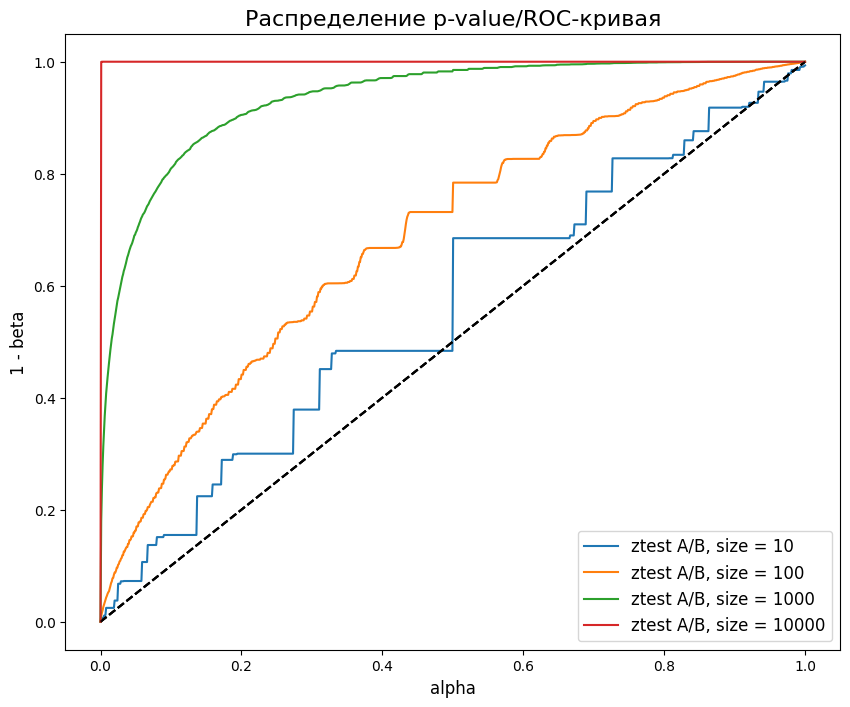

In [32]:
sample_sizes = [10, 100, 1000, 10000]
n_sim = 10**4
plt.figure(figsize=(10, 8))
for s in sample_sizes:
    dict_pvalues = defaultdict(list)
    for _ in range(n_sim):
        x_control, x_treatment = gen_sample(s, effect=0.2, p_control=0.2)
        z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)
        dict_pvalues[f'ztest A/B, size = {s}'].append(pval_ab)
    plot_pvalue_distribution(dict_pvalues)

__ё) [10 баллов]__ Количество наблюдений, ошибка 1 и 2 рода, размер эффекта, который мы ищем и дисперсия в выборках связаны между собой. Для некоторых критериев проверки гипотез можно вывести формулы, которые их связывают. 

В данном случае, формула для расчета числа наблюдений _для одной группы_ выглядит вот так:

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

В приложении Яндекс.Такси в конце поездки вылезают рандомные опросники. В одном из опросников задаётся вопрос «А вы пристёгивались, когда ехали?»

В России, в день, в Такси происходит 1 миллион заказов. Вопрос про ремни задаётся рандомным 10% пользователей, закончивших поездку. Пользователь не игнорирует опросник и отвечает на него да или нет с вероятностью 5% (цифры взяты из головы и не отражают реальную статистику).

Менеджер Екатерина хочет сделать так, чтобы когда пассажир садится в машину, Алиса просила его пристегнуться. Хочется замерить, какой эффект это даст на пристёгивания. Станут ли люди чаще пристёгиваться. Замерять мы это будем опросником. Сейчас 10% пользователей говорят, что пристегнулись. 

Екатерина пришла к вам и между вами состоялся следующий диалог: 

- Хочу АБ-тест с разбивкой 50 на 50.
- Какие ошибки 1 и 2 рода хочешь? 
- Нулевые.
- Нам надо бесконечно наблюдений, готова столько ждать? 
- Нет.
- На сколько мы хотим, чтобы выросла доля ответов да? 
- Если подрастёт хотябы на процент, будет круто.
- То есть если меньше процента, такой эффект считаем неудачей и отсутствием изменения?
- Да. 
- Давай я нарисую тебе табличку с разными ошибками, а внутри на пересечении напишу сколько дней надо ждать, чтобы найти такой минимальный эффект.
- Давай, по ней и примем решение.

Нарисуйте для Екатерины такую табличку. Не забудьте перевести общее количество наблюдений в дни.

In [17]:
p_A = 0.10
p_B = 0.11
sigma_A_sq = p_A * (1 - p_A)
sigma_B_sq = p_B * (1 - p_B)
MDE = 0.01
resp_per_day = 5000

def calculate_sample_size(alpha, beta, MDE, sigma_B_sq, sigma_A_sq):
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(1 - beta)
    n = ((sigma_A_sq + sigma_B_sq) * (z_alpha + z_beta)**2) / MDE**2
    return float(n)

alpha_values = np.arange(0.01, 1, 0.01)
beta_values = np.arange(0.01, 1, 0.01)

res = []
for alpha in alpha_values:
    for beta in beta_values:
        n_one_group = calculate_sample_size(alpha, beta, MDE, sigma_B_sq, sigma_A_sq)
        total_obs = 2 * n_one_group
        days = np.ceil(total_obs / resp_per_day)
        res.append({'alpha': alpha, 'beta': beta, 'days': days})
df = pd.DataFrame(res)
data = df.pivot(index='beta', columns='alpha', values='days')
data

alpha,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
beta,,,,,,,,,,,,,,,,,,,,,
0.01,19.0,17.0,16.0,15.0,14.0,14.0,13.0,13.0,13.0,12.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
0.02,17.0,15.0,14.0,13.0,13.0,12.0,12.0,11.0,11.0,11.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
0.03,15.0,14.0,13.0,12.0,12.0,11.0,11.0,10.0,10.0,10.0,...,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
0.04,15.0,13.0,12.0,11.0,11.0,10.0,10.0,10.0,9.0,9.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
0.05,14.0,12.0,11.0,11.0,10.0,10.0,9.0,9.0,9.0,9.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
0.96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
0.97,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


__ж) [10 баллов]__ Попробуем сломать наш АБ-тест. Когда мы используем z-тест, мы размышляем в терминах центральной предельной теоремы. Тест будет работать, если выполнены предпосылки ЦПТ:

- Наблюдения независимо одинаково распределены
- В данных нет выборосов, дисперсия конечная
- Данных много

Давайте сломаем одно из условий и попробуем собрать выборку из [распределения Парето](https://ru.wikipedia.org/wiki/Распределение_Парето).

In [35]:
def gen_sample(n_obs, effect, b=0.5):
    x_control = stats.pareto(b=b).rvs(n_obs)
    x_treatment = stats.pareto(b=b).rvs(n_obs)
    x_treatment = (1 + effect) * x_treatment
    return x_control, x_treatment

Отрисуйте ROC-кривые для $b=3$, $b=1$, $b=0.5$

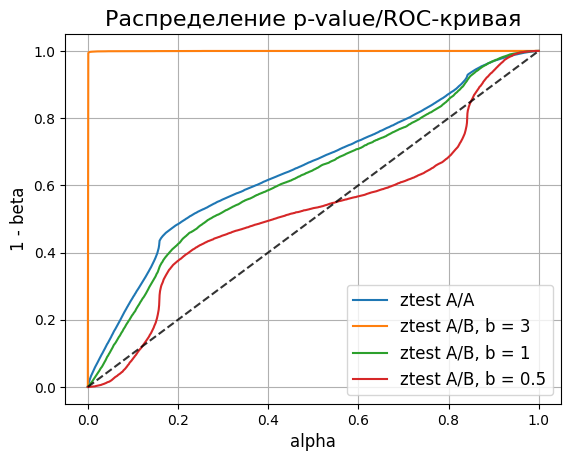

In [38]:
n_sim = 10**4
n_sample = 1000
beta_values = [3, 1, 0.5]
dict_pvalues = defaultdict(list)
for b in beta_values:
    for _ in range(n_sim):
        x_control, x_treatment = gen_sample(n_sample, effect = 0.2, b = b)
        z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)
        x_control_again, _ = gen_sample(s, effect=0, b = b)
        z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)
        
        dict_pvalues['ztest A/A'].append(pval_aa)
        dict_pvalues[f'ztest A/B, b = {b}'].append(pval_ab)

plot_pvalue_distribution(dict_pvalues)

Возьмите при каждом $b$ одну выборку, нарисуйте для неё гистограмму и посмотрите как обстоят дела с выбросами.

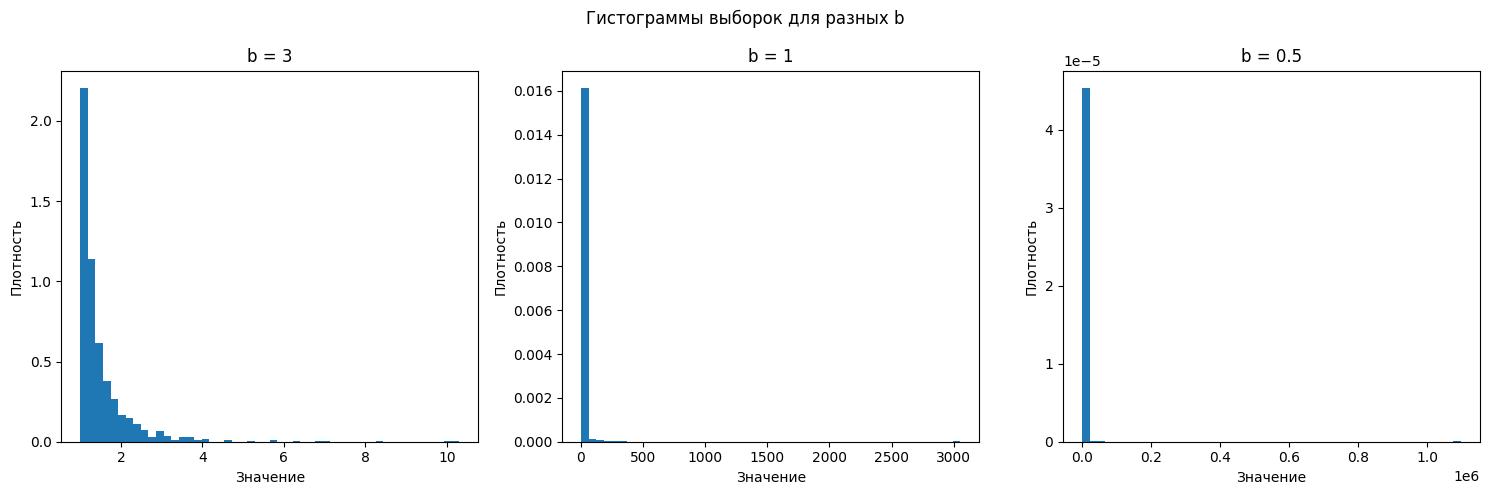

In [20]:
n_sample = 1000
beta_values = [3, 1, 0.5]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].hist(gen_sample(n_sample, effect = 0.2, b = beta_values[i])[0], bins=50, density=True)
    axes[i].set_title(f'b = {beta_values[i]}')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Плотность')
plt.suptitle('Гистограммы выборок для разных b')
plt.tight_layout()
plt.show()

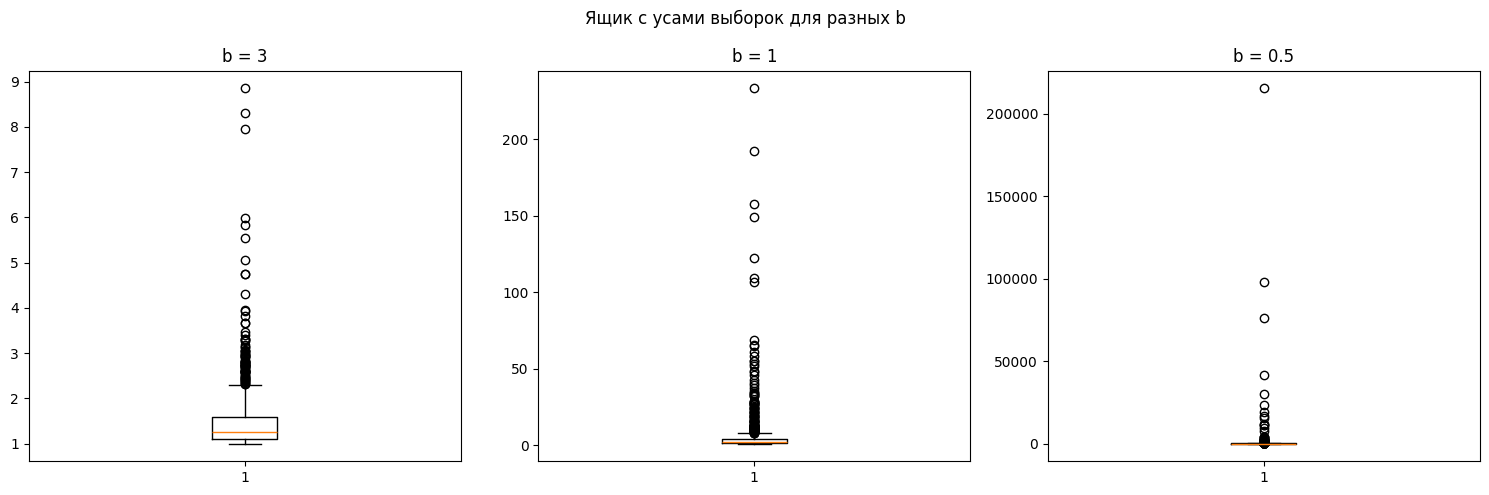

In [21]:
n_sample = 1000
beta_values = [3, 1, 0.5]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].boxplot(gen_sample(n_sample, effect = 0.2, b = beta_values[i])[0])
    axes[i].set_title(f'b = {beta_values[i]}')
plt.suptitle('Ящик с усами выборок для разных b')
plt.tight_layout()
plt.show()

__Ответ:__ Выбросы получились огромные и их много, что характерно для распределения Парето, потому что у него тяжелые хвосты

Конечно, чисто формально, у распределения Парето дисперсия есть. Чисто формально условия ЦПТ не нарушены, но $n$ для работоспособности нашего критерия должно оказаться больше любой биг-даты от биг-техов. 

Возникает вполне резонный вопрос: а что делать в таких ситуациях? Есть несколько дорог. 

- Во-первых, можно отвязаться от математического ожидания и поработать с медианой. Для неё тоже можно вывести асимптотическое распределение с помощью дельта-метода. 
- Во-вторых, можно попробовать другие техники проверки гипотез. Например, бутстрап и непараметрические критерии. 

Об этом мы и будем говорить на следующих парах. 